# Part I: Percolation
---
## Task Allocation
- Sihan Ren

## Description
TBC

## Code & Simulation

111


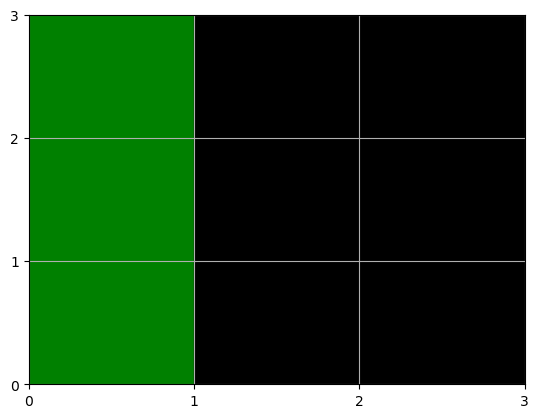

In [101]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

class PercolationGrid():
    def __init__(self, size):
        self.len = size
        self._grid = np.zeros((size, size))
        self.open = 0
        self.percolates = False
        
        block_list = [(i, j) for i in range(size) for j in range(size)]
        random.shuffle(block_list)
        self._block_list = block_list
        # print(block_list)     
        
        
    
    def open_block(self):
        if len(self._block_list)==0:
            raise Exception("No more blocks to open")
        i, j = self._block_list.pop()
        self._grid[i, j] = 1
        self.open += 1
    
    def BFS(self,grid,n): #Not optimized
        # In the grid, 1 means open, 0 means blocked, 2 means visited
        
        directions = [(0, 1), (1, 0), (0, -1), (-1, 0)]  # The direction we can move

        # add a new row on the top, we start from this row
        grid = np.vstack([np.full(n, 2), grid])
        queue = deque([(0, i) for i in range(n)])

        bound_r = n+1
        bound_c = n

        while queue:
            r, c = queue.popleft()
            if r == n:
                return True, grid
            for dr, dc in directions:
                nr, nc = r + dr, c + dc
                if 0 <= nr < bound_r and 0 <= nc < bound_c and grid[nr, nc] == 1:
                    queue.append((nr, nc))
                    grid[nr, nc] = 2
        return False, grid
    
    def check_percolates(self):
        self.percolates,_ = self.BFS(np.copy(self._grid), self.len)
        return self.percolates
    
    def visualize(self):
        vis_grid = np.copy(self._grid)
        _, vis_grid = self.BFS(vis_grid, self.len)
        vis_grid = vis_grid[1:, :]
        
        color_map = {1: 'white', 0: 'black', 2: 'green'}
        n = self.len

        fig, ax = plt.subplots()
        ax.set_xlim(0, n)
        ax.set_ylim(0, n)
        ax.set_xticks(range(n + 1))
        ax.set_yticks(range(n + 1))
        ax.grid(True)

        for x in range(n):
            for y in range(n):
                ax.add_patch(plt.Rectangle((y, n-x-1), 1, 1, color=color_map[vis_grid[x, y]]))

    plt.show()
        
while True:
    test_1 = PercolationGrid(3)
    test_1.open_block()
    # test_1.visualize()
    test_1.open_block()
    # test_1.visualize()
    test_1.open_block()
    # test_1.visualize()
    if (test_1.check_percolates()):
        print(111)
        test_1.visualize()
        break
